In [1]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tqdm import tqdm
# from tools import process_run, process_run_csv
from tools import process_run, process_run_csv
# from prossesing_tools import process_waveform, process_all_waveforms
# procdf = pd.DataFrame(detector_hits.groupby(['event','volID','iRep'], as_index=False)['Edep'].sum())
# procdf = procdf.rename(columns={'iRep':'detID', 'Edep':'energy'})

In [2]:
from tqdm import tqdm
import pandas as pd

# Initialize an empty DataFrame to hold all runs data
all_runs_df = pd.DataFrame()

# Specify your runs and file paths
run_start = 0
run_end = 25  # For example, if you have runs 0 through 9
base_directory = "/work/users/k/b/kbhimani/cpu_net_g4sims/data_ornl/"
base_filename = "data_run_{}.csv"
offset = 1000000 + 1

energy_ranges = {
    (2614, 2615): "fep_wf",
    (2103, 2104): "sep_wf",
    (1592, 1593): "dep_wf"
}

cut_energy = True  # Flag to enable/disable energy range filtering

# Process each run and concatenate the results
for run_number in tqdm(range(run_start, run_end)):
    filename = base_directory + base_filename.format(run_number)
    run_df = process_run_csv(filename, run_number, offset)  # Assuming this function already exists

    if cut_energy:
        # Filter run_df for specified energy ranges before concatenating
        filtered_run_df = pd.DataFrame()
        for energy_range, label in energy_ranges.items():
            min_energy, max_energy = energy_range
            temp_df = run_df.loc[(run_df['e_total'] >= min_energy) & (run_df['e_total'] <= max_energy)].copy()
            temp_df['energy_label'] = label  # Optional: Add a column to label the energy range
            filtered_run_df = pd.concat([filtered_run_df, temp_df])
        all_runs_df = pd.concat([all_runs_df, filtered_run_df])
    else:
        # If not filtering by energy, concatenate the entire run_df
        all_runs_df = pd.concat([all_runs_df, run_df])

# Reset index after concatenating
all_runs_df.reset_index(drop=True, inplace=True)

unique_events_df = all_runs_df.drop_duplicates(subset='event')
unique_events_df.head()

100%|██████████| 25/25 [04:06<00:00,  9.84s/it]


,event,x_hit,y_hit,z_hit,edep,volID,detID,e_total,energy_label
0,145,27.60190,5.66216,49.0847,0.05912,1,0,2614.50480,fep_wf
22,189,18.53330,25.42230,92.3964,0.10126,1,0,2614.50282,fep_wf
38,259,2.03355,14.15180,91.3792,0.02759,1,0,2614.50400,fep_wf
56,515,6.23909,-11.73620,40.0486,0.14340,1,0,2614.50290,fep_wf
76,517,11.24820,33.03960,97.3262,0.13732,1,0,2614.50200,fep_wf


In [16]:
len(unique_events_df)

160864

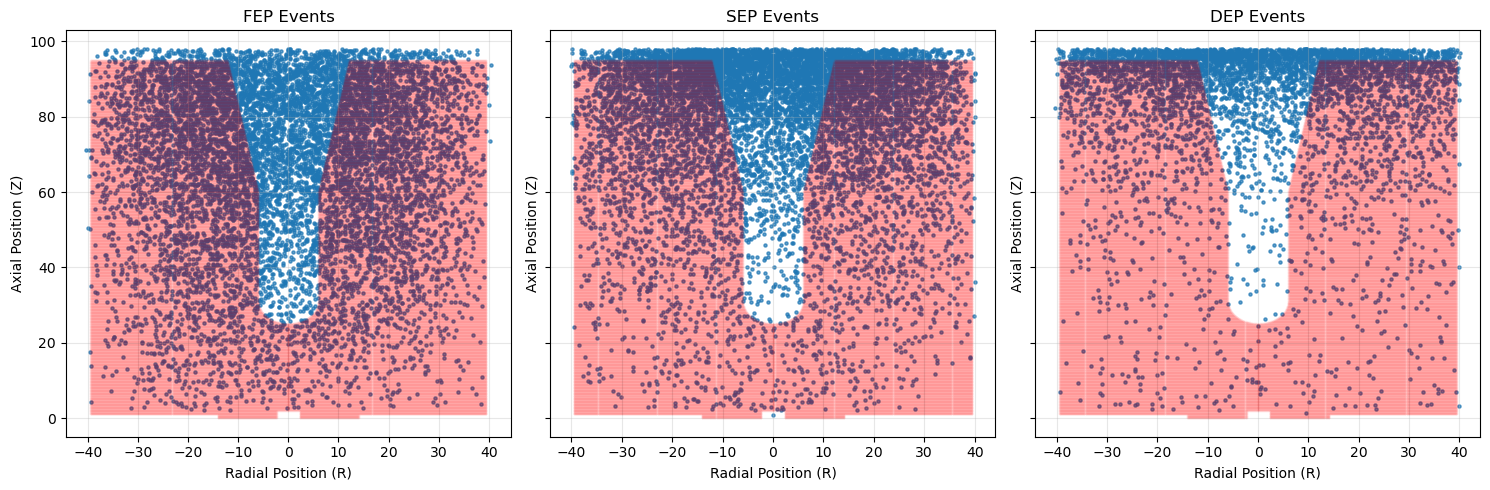

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

# Load and preprocess electric field data
field_data = np.loadtxt('/nas/longleaf/home/kbhimani/ornl_sims/icpc_siggen/fields/ev_V06649A.dat')

# Extract valid electric field points
valid_field_indices = field_data[:, 3] > 0  # Assuming a valid field magnitude is > 0
valid_field_data = field_data[valid_field_indices]

# Extract grid points and field magnitude
valid_x = valid_field_data[:, 0]
valid_y = valid_field_data[:, 1]
valid_field_magnitude = valid_field_data[:, 3]

# Create symmetric detector boundary (mirror the negative x-axis)
valid_x_symmetric = np.concatenate((-valid_x, valid_x))
valid_y_symmetric = np.concatenate((valid_y, valid_y))

# Define a function to create scatter plots with the detector boundary
def plot_hits_subplot(ax, data, title):
    """
    Creates a scatter plot of R vs Z on a given axis and overlays the symmetric detector boundary.

    Parameters:
        ax (Axes): Matplotlib Axes object where the plot will be drawn.
        data (DataFrame): The filtered data for the specific energy label.
        title (str): The title for the subplot.
    """
    
    # Draw symmetric detector boundary
    ax.plot(valid_x_symmetric, valid_y_symmetric, 'r.', markersize=0.5, alpha=0.05)
    
    # Scatter plot of hit positions
    ax.scatter(data['x_hit'], data['z_hit'], alpha=0.7, s=5, label="Hits")


    # Add labels, title, and grid
    ax.set_xlabel("Radial Position (R)", fontsize=10)
    ax.set_ylabel("Axial Position (Z)", fontsize=10)
    ax.set_title(title, fontsize=12)
    ax.grid(alpha=0.3)

# Define the number of events to include
num_event = 10000  # Change this value to the desired number of unique events

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Define titles for the plots
titles = ["FEP Events", "SEP Events", "DEP Events"]

# Iterate over energy ranges and axes
for i, (energy_range, label) in enumerate(energy_ranges.items()):
    filtered_data = unique_events_df[unique_events_df['energy_label'] == label]
    
    # Get the first num_event unique events
    first_n_events = filtered_data['event'].drop_duplicates().iloc[:num_event]
    
    # Filter the data to include only rows belonging to the first num_event unique events
    filtered_data_n = filtered_data[filtered_data['event'].isin(first_n_events)]
    
    # Plot on the corresponding subplot with detector boundary
    plot_hits_subplot(axes[i], filtered_data_n, titles[i])

# Adjust layout and show the plots
plt.savefig('figs/event_hits_eng.png')
plt.tight_layout()
plt.show()


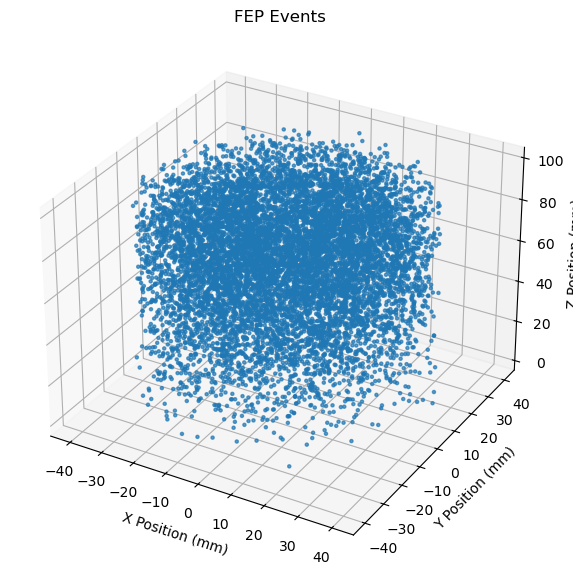

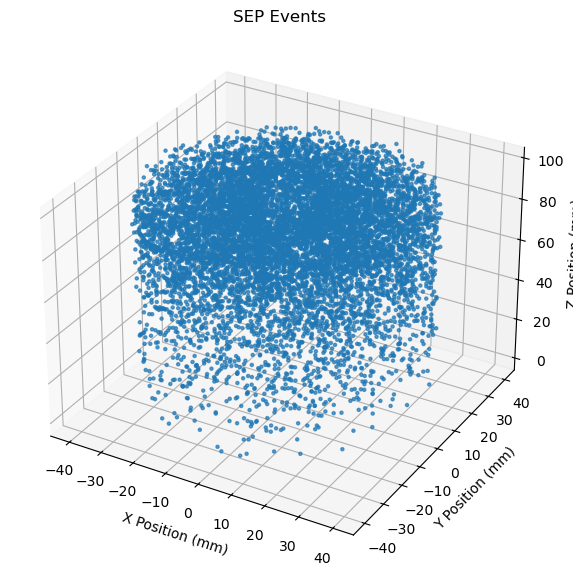

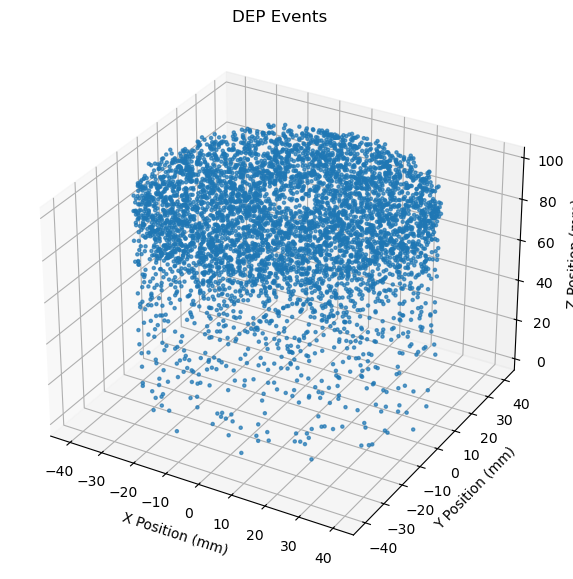

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define function to plot event distributions in 3D
def plot_events_3D(event_data, title, save_path):
    """
    Creates a 3D scatter plot of event hits in the detector.

    Parameters:
        event_data (DataFrame): Data containing event hit positions.
        title (str): Title for the plot.
        save_path (str): Path to save the figure.
    """
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot of event hits
    ax.scatter(event_data['x_hit'], event_data['y_hit'], event_data['z_hit'], 
               alpha=0.7, s=5)

    # Labels and title
    ax.set_xlabel("X Position (mm)")
    ax.set_ylabel("Y Position (mm)")
    ax.set_zlabel("Z Position (mm)")
    ax.set_title(title)

    # Save and show
    plt.savefig(save_path, dpi=300)
    plt.show()


# Define event labels for FEP, SEP, and DEP
event_labels = {
    "fep_wf": "FEP Events",
    "sep_wf": "SEP Events",
    "dep_wf": "DEP Events"
}

# Number of unique events to include
num_event = 10000  # Adjust this as needed

# Iterate over event labels and plot separately
for label, title in event_labels.items():
    filtered_data = unique_events_df[unique_events_df['energy_label'] == label]

    # Get the first num_event unique events
    first_n_events = filtered_data['event'].drop_duplicates().iloc[:num_event]

    # Filter data for only the first num_event unique events
    filtered_data_n = filtered_data[filtered_data['event'].isin(first_n_events)]

    # Define save path
    save_path = f"figs/{label}_3D.png"

    # Plot the events in 3D
    plot_events_3D(filtered_data_n, title, save_path)


In [4]:
# print(all_runs_df)
# all_runs_df.to_csv("event_map.csv")
np.save("/nas/longleaf/home/kbhimani/CPU-Net/paper/plot_data/eng_spec_sim.npy", unique_events_df["e_total"])

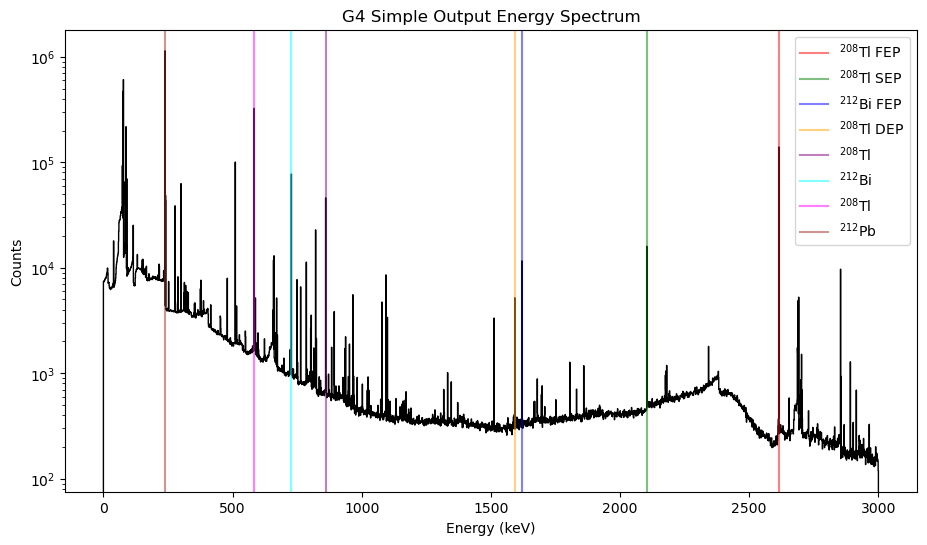

In [5]:
eng_spec_sim = np.load("/nas/longleaf/home/kbhimani/CPU-Net/paper/plot_data/eng_spec_sim.npy")

plt.figure(figsize=(11, 6))
hist, bins, _ = plt.hist(eng_spec_sim, bins=3000, range=(0, 3000), histtype='step', color='k')
plt.yscale('log')

# Define peak energies, labels, and colors
peaks = [
    (2614.53, r'$^{208}$Tl FEP', 'red'),
    (2103.53, r'$^{208}$Tl SEP', 'green'),
    (1620.5, r'$^{212}$Bi FEP', 'blue'),
    (1592.53, r'$^{208}$Tl DEP', 'orange'),
    (860.56, r'$^{208}$Tl', 'purple'),
    (727.2, r'$^{212}$Bi', 'cyan'),
    (583.2, r'$^{208}$Tl', 'magenta'),
    (238.4, r'$^{212}$Pb', 'brown')
]

# Draw lines and add labels to legend
for energy, label, color in peaks:
    plt.axvline(energy, color=color, alpha=0.5, label=label)

plt.xlabel('Energy (keV)')
plt.ylabel('Counts')
plt.title('G4 Simple Output Energy Spectrum')
plt.legend(loc='upper right')
# plt.savefig("figs/eng_cal_th.png",dpi=200)
plt.show()


         event     x_hit    y_hit    z_hit       edep  volID  detID  \
140855     169 -8.213740  8.38115  93.8675  779.11000      1      0   
140856     169 -8.182070  8.40401  93.7865  450.06400      1      0   
140857     169 -6.936800  4.00333  49.7304    0.09277      1      0   
140858     169 -6.936800  4.00333  49.7304    0.02561      1      0   
140859     169 -6.936800  4.00333  49.7304    0.00926      1      0   
...        ...       ...      ...      ...        ...    ...    ...   
155035  999652  6.250680 -2.71230  80.6064    8.62140      1      0   
155036  999652  6.260760 -2.71375  80.6072  124.72500      1      0   
155037  999652 -3.443690  9.06298  79.7490  127.50900      1      0   
155038  999652  0.647885 -7.79347  73.3327  247.69800      1      0   
155039  999652 -5.977000 -7.54758  67.6355  721.89500      1      0   

           e_total energy_label  
140855  2103.50529       sep_wf  
140856  2103.50529       sep_wf  
140857  2103.50529       sep_wf  
140858  210

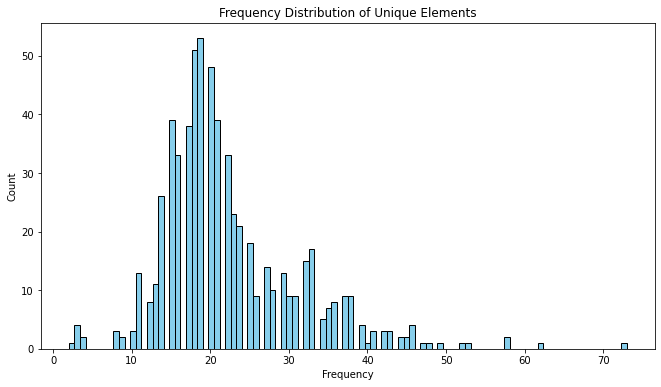

In [5]:
# filtered_df = all_runs_df[(all_runs_df['e_total'] >= 2614) & (all_runs_df['e_total'] <= 2615)]
filtered_df = all_runs_df[(all_runs_df['e_total'] >= 2103) & (all_runs_df['e_total'] <= 2104)]
# filtered_df = all_runs_df[(all_runs_df['e_total'] >= 1592) & (all_runs_df['e_total'] <= 1593)]
# This counts occurrences of each unique event in the filtered range
print(filtered_df)
unique_elements, frequencies = np.unique(filtered_df['event'], return_counts=True)
plt.figure(figsize=(11, 6))
x=plt.hist(frequencies, bins=100, color='skyblue', edgecolor='black')
plt.title('Frequency Distribution of Unique Elements')
plt.xlabel('Frequency')
plt.ylabel('Count')
plt.show()


In [6]:
print(all_runs_df)

            event    x_hit     y_hit    z_hit        edep  volID  detID  \
0             145  27.6019   5.66216  49.0847     0.05912      1      0   
1             145  27.6019   5.66216  49.0847     0.00863      1      0   
2             145  27.6019   5.66216  49.0847     0.00926      1      0   
3             145  27.6019   5.66217  49.0847     1.14579      1      0   
4             145  27.5793   5.62257  48.9989     0.11447      1      0   
...           ...      ...       ...      ...         ...    ...    ...   
3186870  19986705  13.0215   5.80391  31.3036   420.67300      1      0   
3186871  19986705  13.2979   5.72199  31.0399   931.78100      1      0   
3186872  19986705  13.2824   5.72856  31.0152   240.05300      1      0   
3186873  19999466  23.3312 -19.12530  63.9196  1136.49000      1      0   
3186874  19999466  23.3644 -19.19290  63.9486   455.98400      1      0   

           e_total energy_label  
0        2614.5048       fep_wf  
1        2614.5048       fep_wf

  0%|          | 0/5515 [00:02<?, ?it/s]


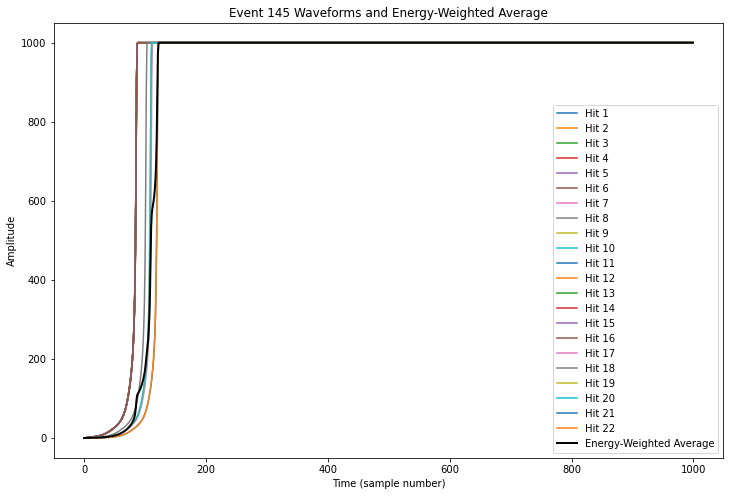

In [7]:
import subprocess
import os
import struct
import numpy as np
import pandas as pd

# Setup
config_path = "/nas/longleaf/home/kbhimani/ornl_sims/icpc_siggen/config_files/V06649A.config"
siggen_dir = "/nas/longleaf/home/kbhimani/ornl_sims/icpc_siggen/"
stester_executable = os.path.join(siggen_dir, "stester")
os.chdir(siggen_dir)
wf_len=1000 #based on output of siggen
# Energy ranges and corresponding folder names
energy_ranges = {
    (2614, 2615): "fep_wf",
    (2103, 2104): "sep_wf",
    (1592, 1593): "dep_wf"
}

for energy_range, folder_name in energy_ranges.items():
    # Filter the DataFrame for the specific energy range
    filtered_df = all_runs_df[(all_runs_df['e_total'] >= energy_range[0]) & (all_runs_df['e_total'] <= energy_range[1])]
    
    # Check if the filtered DataFrame is empty
    if filtered_df.empty:
        print(f"No events found in the energy range {energy_range}.")
        continue

    # Define the output directory for this energy range
    output_dir = os.path.join(siggen_dir, "waveforms", folder_name)
    
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Process each unique event in the filtered DataFrame
    for event_id in tqdm(filtered_df['event'].unique()):
        event_hits = filtered_df[filtered_df['event'] == event_id]
        
        # Prepare stester commands
        command_file_path = os.path.join(output_dir, f"my_stester_commands_event_{event_id}.txt")
        with open(command_file_path, "w") as f:
            f.write("cart \n")
            f.write("tau 0\n")
            f.write("dif 1\n")
            f.write("ccs 0.1\n")
            for index, hit in event_hits.iterrows():
                waveform_filename = f"waveform_event{event_id}_hit{index}.spe"
                waveform_path = os.path.join(output_dir, waveform_filename)
                f.write(f"sig {hit['x_hit']:.2f} {hit['y_hit']:.2f} {hit['z_hit']:.2f} {waveform_path}\n")
            f.write("quit\n")
        
        # Run stester
        stester_command = f"{stester_executable} {config_path} < {command_file_path}"
        subprocess.run(stester_command, shell=True, check=False, stdout=subprocess.DEVNULL)
        os.remove(command_file_path)  # Clean up command file

        # Initialize a list to hold the individual hit waveforms
        hit_waveforms = []
        # Initialize variables for aggregation
        aggregate_waveform = np.zeros(wf_len)  # Assuming wf_len samples per waveform
        total_deposited_energy = 0  # Track the total deposited energy

        # Process each waveform file
        for index, hit in event_hits.iterrows():
            waveform_filename = f"waveform_event{event_id}_hit{index}.spe"
            waveform_path = os.path.join(output_dir, waveform_filename)
            edep = hit['edep']

            try:
                with open(waveform_path, 'rb') as f:
                    head = f.read(36)  # Skip header
                    yraw = f.read(wf_len*4)  # Read waveform data
                    wf = np.array(struct.unpack('f'*wf_len, yraw))
                    # Save the waveform for plotting
                    hit_waveforms.append(wf)
                    aggregate_waveform += wf * edep
                    total_deposited_energy += edep
                os.remove(waveform_path)  # Clean up waveform file
            except Exception as e:
                # print(f"Error processing file {waveform_path}: {e}")
                continue

        # Compute the energy-weighted average waveform
        if total_deposited_energy > 0:
            average_waveform = aggregate_waveform / total_deposited_energy
            average_waveform = np.nan_to_num(average_waveform)
        else:
            # print(f"Error: No deposited energy detected for event {event_id}.")
            continue

        # Save the energy-weighted average waveform
        average_waveform_filename = f"waveform_event_{event_id}_energy_{energy}.txt"
        average_waveform_path = os.path.join(output_dir, average_waveform_filename)
        np.savetxt(average_waveform_path, average_waveform)
        # print(f"Energy-weighted average waveform for event {event_id} saved in {folder_name}.")
        break
    break
# Compute the energy-weighted average waveform
if total_deposited_energy > 0:
    average_waveform = aggregate_waveform / total_deposited_energy
    average_waveform = np.nan_to_num(average_waveform)
else:
    print(f"Error: No deposited energy detected for event {event_id}.")
    # Proceed to plotting even if there's an error
    
# Save the hit waveforms and the aggregated waveform
np.savez('event_waveforms_data.npz', hit_waveforms=hit_waveforms, average_waveform=average_waveform)

# To load the data back into Python:
data = np.load('event_waveforms_data.npz')
loaded_hit_waveforms = data['hit_waveforms']
loaded_average_waveform = data['average_waveform']

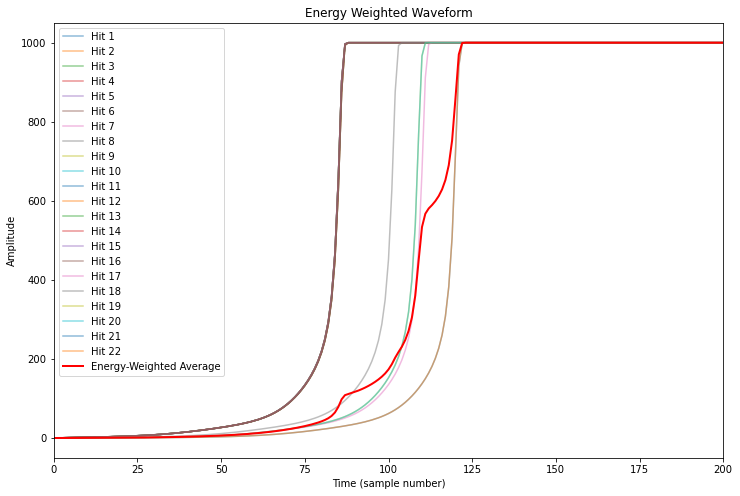

In [23]:
# Load the saved data
data = np.load('event_waveforms_data.npz')
hit_waveforms = data['hit_waveforms']
average_waveform = data['average_waveform']
plt.figure(figsize=(12, 8))
# Plot each hit waveform
for i, wf in enumerate(hit_waveforms):
    plt.plot(wf, label=f'Hit {i+1}', alpha=0.5)

# Plot the aggregated waveform
plt.plot(average_waveform, color='r', linewidth=2, label='Energy-Weighted Average')
plt.xlim(0,200)
plt.title(f'Energy Weighted Waveform')
plt.xlabel('Time (sample number)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

/nas/longleaf/home/kbhimani/ornl_sims/icpc_siggen/waveforms/fep_wf


100%|██████████| 110404/110404 [10:00<00:00, 183.96it/s]


/nas/longleaf/home/kbhimani/ornl_sims/icpc_siggen/waveforms/dep_wf


100%|██████████| 2989/2989 [00:13<00:00, 227.76it/s]


/nas/longleaf/home/kbhimani/ornl_sims/icpc_siggen/waveforms/sep_wf


100%|██████████| 12701/12701 [01:13<00:00, 173.88it/s]


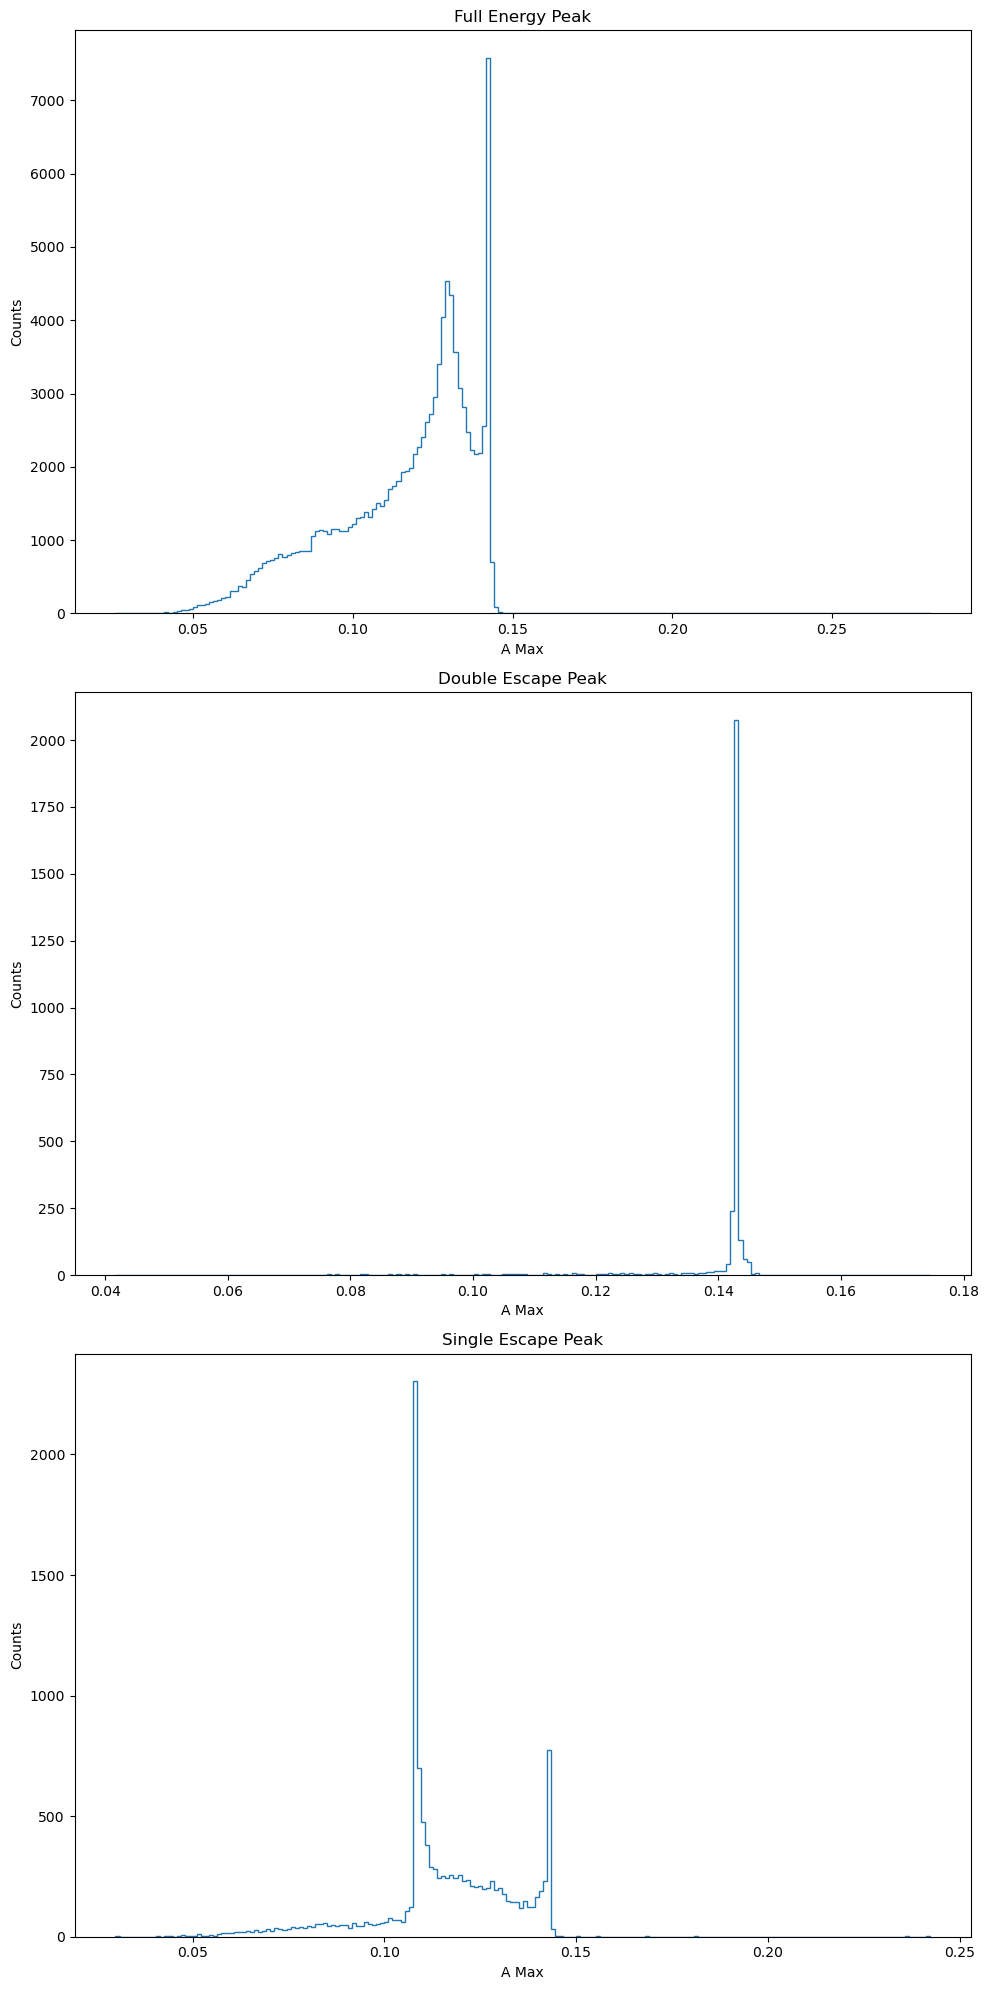

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dspeed.processors import avg_current, upsampler, moving_window_multi, min_max
import os
from tqdm import tqdm
from prossesing_tools import process_all_waveforms

# Assuming the process_waveform function is defined as in the previous example
# but without the plotting part for simplicity here

energy_ranges = {
    "fep_wf": "Full Energy Peak",
    "dep_wf": "Double Escape Peak",
    "sep_wf": "Single Escape Peak"
}

A_max_all_ranges = {}

for energy_range, label in energy_ranges.items():
    try:
        directory = f"/nas/longleaf/home/kbhimani/ornl_sims/icpc_siggen/waveforms/{energy_range}"
        print(directory)
        A_max_values = process_all_waveforms(directory)
        A_max_all_ranges[energy_range] = A_max_values
    except FileNotFoundError:
        continue
# Create separate histograms for each energy range
fig, axes = plt.subplots(len(energy_ranges), 1, figsize=(10, 20))

for i, (energy_range, A_max_values) in enumerate(A_max_all_ranges.items()):
    ax = axes[i]
    rg=200
    # rg = np.linspace(0.10,0.145,200)
    ax.hist(A_max_values, bins=rg, histtype="step", color="tab:blue")
    ax.set_title(energy_ranges[energy_range])
    ax.set_xlabel("A Max")
    ax.set_ylabel("Counts")

plt.tight_layout()
plt.show()

In [3]:
from tqdm import tqdm
import numpy as np
import pickle
import os
from prossesing_tools import calculate_tn
from dspeed.processors import time_point_thresh
from dspeed.errors import DSPFatal
# Define your energy ranges and corresponding directories
energy_ranges = {
    (2614, 2615): "fep_wf",
    (2103, 2104): "sep_wf",
    (1592, 1593): "dep_wf"
}

pickle_output_dir = "/nas/longleaf/home/kbhimani/ornl_sims/sim_wf_pkl"
os.makedirs(pickle_output_dir, exist_ok=True)  # Ensure the directory exists

def save_waveforms_to_pickle(energy_ranges, pickle_output_dir, siggen_dir):
    for energy_range, label in energy_ranges.items():
        waveform_dir = os.path.join(siggen_dir, "waveforms", label)

        if not os.path.exists(waveform_dir):
            print(f"Directory {waveform_dir} does not exist. Skipping.")
            continue

        waveform_files = [f for f in os.listdir(waveform_dir) if f.startswith('waveform_event')]
        pickle_filename = f"{label}_sim.pickle"
        pickle_path = os.path.join(pickle_output_dir, pickle_filename)

        # Open the pickle file once for appending each event dictionary
        with open(pickle_path, 'wb') as f:
            i=0
            for wf_file in tqdm(waveform_files, desc=f"Processing {label}"):
                # if i==10000:
                #     break
                try:
                    # Extract event_id and energy directly from the filename
                    parts = wf_file.split('_')
                    event_id = int(parts[2])
                    energy_str = parts[4].split('.')[0]  # Assuming the energy is before the file extension
                    energy = float(energy_str)
                    i+=1
                except ValueError:
                    print(f"Skipping file with unexpected format: {wf_file}")
                    continue

                waveform_path = os.path.join(waveform_dir, wf_file)
                waveform = np.loadtxt(waveform_path)

                if np.isnan(waveform).any() or np.isinf(waveform).any():
                    print(f"Skipping event {event_id} due to invalid waveform data.")
                    continue
                    
                 # Calculate t90 for the waveform
                # t90 = calculate_tn(waveform, 99)
                
                event_dict = {
                    "tp0": 0,
                    "wf": waveform.astype(np.float32),
                    "event": event_id,
                    "energy": energy,
                }

                # Dump each event dictionary individually to the pickle file
                pickle.dump(event_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

            print(f"Completed saving waveforms for {label}")

siggen_dir = "/nas/longleaf/home/kbhimani/ornl_sims/icpc_siggen/"
save_waveforms_to_pickle(energy_ranges, pickle_output_dir, siggen_dir)

Processing fep_wf: 100%|██████████| 110403/110403 [04:33<00:00, 403.98it/s]


Completed saving waveforms for fep_wf


Processing sep_wf: 100%|██████████| 12701/12701 [01:26<00:00, 147.06it/s]


Completed saving waveforms for sep_wf


Processing dep_wf: 100%|██████████| 2989/2989 [01:19<00:00, 37.60it/s] 

Completed saving waveforms for dep_wf


In [3]:
import pickle
test_wf=[]
sim_pulses="/nas/longleaf/home/kbhimani/ornl_sims/sim_wf_pkl/fep_wf_sim.pickle"
with open(sim_pulses, "rb") as openfile:
    while True:
        try:
            wdict = pickle.load(openfile, encoding='latin1')
            print(wdict.keys())  # Add this line to debug
            wf = wdict["wf"]
            test_wf.append(wf)
            # Process wf as needed here
        except EOFError:
            break  # Exit the loop when end of file is reached
        except KeyError:
            print("Key 'wf' not found in dictionary.")
            continue  # Continue to the next iteration if 'wf' key is missing
        # You can add more except blocks as needed for handling other exceptions
        break

dict_keys(['tp0', 'wf', 'event', 'energy'])


In [4]:
# Assume test_wf[0] is your waveform
print(f"t90: {t90}")


t90: 121


(0.0, 200.0)

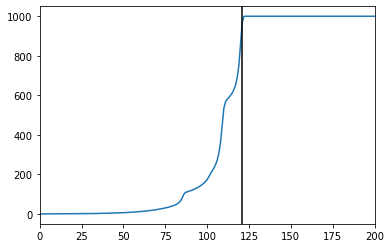

In [6]:
plt.plot(test_wf[0])
plt.axvline(calculate_t90(test_wf[0]),c='k', markersize=0.5)
plt.xlim(0,200)

Error processing file /nas/longleaf/home/kbhimani/ornl_sims/icpc_siggen/waveforms/demo_hits/waveform_event63_hit682.spe: [Errno 2] No such file or directory: '/nas/longleaf/home/kbhimani/ornl_sims/icpc_siggen/waveforms/demo_hits/waveform_event63_hit682.spe'
Error processing file /nas/longleaf/home/kbhimani/ornl_sims/icpc_siggen/waveforms/demo_hits/waveform_event64_hit703.spe: [Errno 2] No such file or directory: '/nas/longleaf/home/kbhimani/ornl_sims/icpc_siggen/waveforms/demo_hits/waveform_event64_hit703.spe'
Error processing file /nas/longleaf/home/kbhimani/ornl_sims/icpc_siggen/waveforms/demo_hits/waveform_event64_hit705.spe: [Errno 2] No such file or directory: '/nas/longleaf/home/kbhimani/ornl_sims/icpc_siggen/waveforms/demo_hits/waveform_event64_hit705.spe'
Error processing file /nas/longleaf/home/kbhimani/ornl_sims/icpc_siggen/waveforms/demo_hits/waveform_event64_hit707.spe: [Errno 2] No such file or directory: '/nas/longleaf/home/kbhimani/ornl_sims/icpc_siggen/waveforms/demo_hi

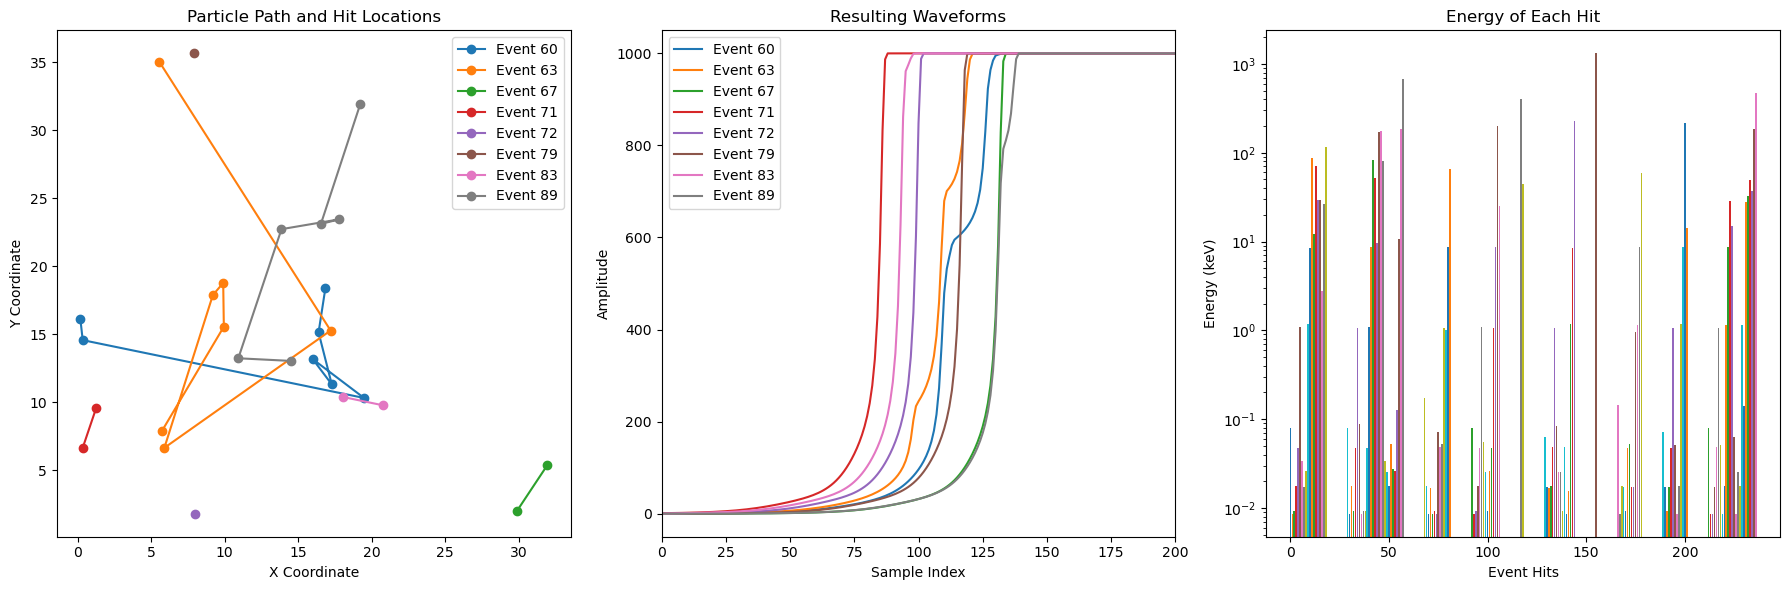

In [2]:
import pandas as pd
import numpy as np
import os
import struct
import subprocess
import matplotlib.pyplot as plt
from tools import process_run_csv  # Ensure this function is properly defined to handle CSV processing.

# Specify parameters
base_directory = "/work/users/k/b/kbhimani/cpu_net_g4sims/data_ornl/"
base_filename = "data_run_0.csv"
siggen_dir = "/nas/longleaf/home/kbhimani/ornl_sims/icpc_siggen/"
config_path = "/nas/longleaf/home/kbhimani/ornl_sims/icpc_siggen/config_files/V06649A.config"
stester_executable = os.path.join(siggen_dir, "stester")
output_dir = os.path.join(siggen_dir, "waveforms", "demo_hits")
os.makedirs(output_dir, exist_ok=True)
wf_len = 1000  # Waveform length.
offset = 1000000 + 1  # Offset for processing.

# Read and process data using process_run_csv
filename = os.path.join(base_directory, base_filename)
run_df = process_run_csv(filename, 0, offset)

# Parameters
selected_events = run_df['event'].unique()[20:30]  # Ensure at least 3 unique events exist.
distance_threshold = 1.0  # Minimum distance to consider a hit.

# Prepare plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Initialize for compressed x-axis
gap_scaling_factor = 10  # Adjust this to control the gap size between events.
compressed_x = []  # Store compressed x-axis values for hits.
compressed_colors = []  # Store colors corresponding to each event.

colors = [
    "#4477AA",  # Blue
    "#EE6677",  # Red
    "#228833",  # Green
    "#CCBB44",  # Yellow
    "#66CCEE",  # Sky Blue
]


# Process selected events
current_x = 0
for event_idx, event_id in enumerate(selected_events):
    event_hits = run_df[run_df['event'] == event_id]

    # Write stester command file
    command_file_path = os.path.join(output_dir, f"stester_commands_event_{event_id}.txt")
    with open(command_file_path, "w") as f:
        f.write("cart \n")
        f.write("tau 0\n")
        f.write("dif 1\n")
        f.write("ccs 0.1\n")
        for index, hit in event_hits.iterrows():
            waveform_filename = f"waveform_event{event_id}_hit{index}.spe"
            waveform_path = os.path.join(output_dir, waveform_filename)
            f.write(f"sig {abs(hit['x_hit']):.2f} {abs(hit['y_hit']):.2f} {hit['z_hit']:.2f} {waveform_path}\n")
        f.write("quit\n")

    # Run stester
    stester_command = f"{stester_executable} {config_path} < {command_file_path}"
    subprocess.run(stester_command, shell=True, check=False, stdout=subprocess.DEVNULL)
    os.remove(command_file_path)  # Clean up command file.

    # Initialize for aggregation
    aggregate_waveform = np.zeros(wf_len)
    total_deposited_energy = 0

    # Process waveform files
    for index, hit in event_hits.iterrows():
        waveform_filename = f"waveform_event{event_id}_hit{index}.spe"
        waveform_path = os.path.join(output_dir, waveform_filename)
        edep = hit['edep']

        try:
            with open(waveform_path, 'rb') as f:
                f.read(36)  # Skip header.
                yraw = f.read(wf_len * 4)  # Read waveform data.
                wf = np.array(struct.unpack('f' * wf_len, yraw))
                aggregate_waveform += wf * edep
                total_deposited_energy += edep
            os.remove(waveform_path)  # Clean up waveform file.
        except Exception as e:
            print(f"Error processing file {waveform_path}: {e}")
            continue

    # Compute energy-weighted average waveform
    if total_deposited_energy > 0:
        average_waveform = aggregate_waveform / total_deposited_energy
        average_waveform = np.nan_to_num(average_waveform)

        # Plot hit locations and particle path on the left
        positions = event_hits[['x_hit', 'y_hit']].to_numpy()
        distances = np.linalg.norm(np.diff(positions, axis=0), axis=1)

        # Filter hits that are too close
        valid_hits = [positions[0]]  # Always include the first hit.
        for i in range(1, len(positions)):
            if distances[i - 1] > distance_threshold:
                valid_hits.append(positions[i])
        valid_hits = np.array(valid_hits)

        # Plot the path
        axes[0].plot(abs(valid_hits[:, 0]), abs(valid_hits[:, 1]), marker='o', label=f'Event {event_id}')
        
        # Plot waveforms in the middle
        axes[1].plot(average_waveform, label=f'Event {event_id}')
        
    # Assign compressed x-axis values for this event
    hit_count = len(event_hits)
    compressed_x.extend(np.arange(current_x, current_x + hit_count))
    current_x += hit_count + gap_scaling_factor  # Add scaled gap to the next event's starting point.

# Plot energy of each hit on the right
for x, edep in zip(compressed_x, run_df.loc[run_df['event'].isin(selected_events), 'edep']):
    axes[2].bar(x, edep, log=True)

# Finalize plots
axes[0].set_title("Particle Path and Hit Locations")
axes[0].set_xlabel("X Coordinate")
axes[0].set_ylabel("Y Coordinate")
axes[0].legend()

axes[1].set_title("Resulting Waveforms")
axes[1].set_xlabel("Sample Index")
axes[1].set_ylabel("Amplitude")
axes[1].set_xlim(0, 200)  # Set x-axis limits
axes[1].legend()

axes[2].set_title("Energy of Each Hit")
axes[2].set_xlabel("Event Hits")
axes[2].set_ylabel("Energy (keV)")

plt.tight_layout()
plt.show()


Error processing file /nas/longleaf/home/kbhimani/ornl_sims/icpc_siggen/waveforms/demo_hits/waveform_event63_hit682.spe: [Errno 2] No such file or directory: '/nas/longleaf/home/kbhimani/ornl_sims/icpc_siggen/waveforms/demo_hits/waveform_event63_hit682.spe'


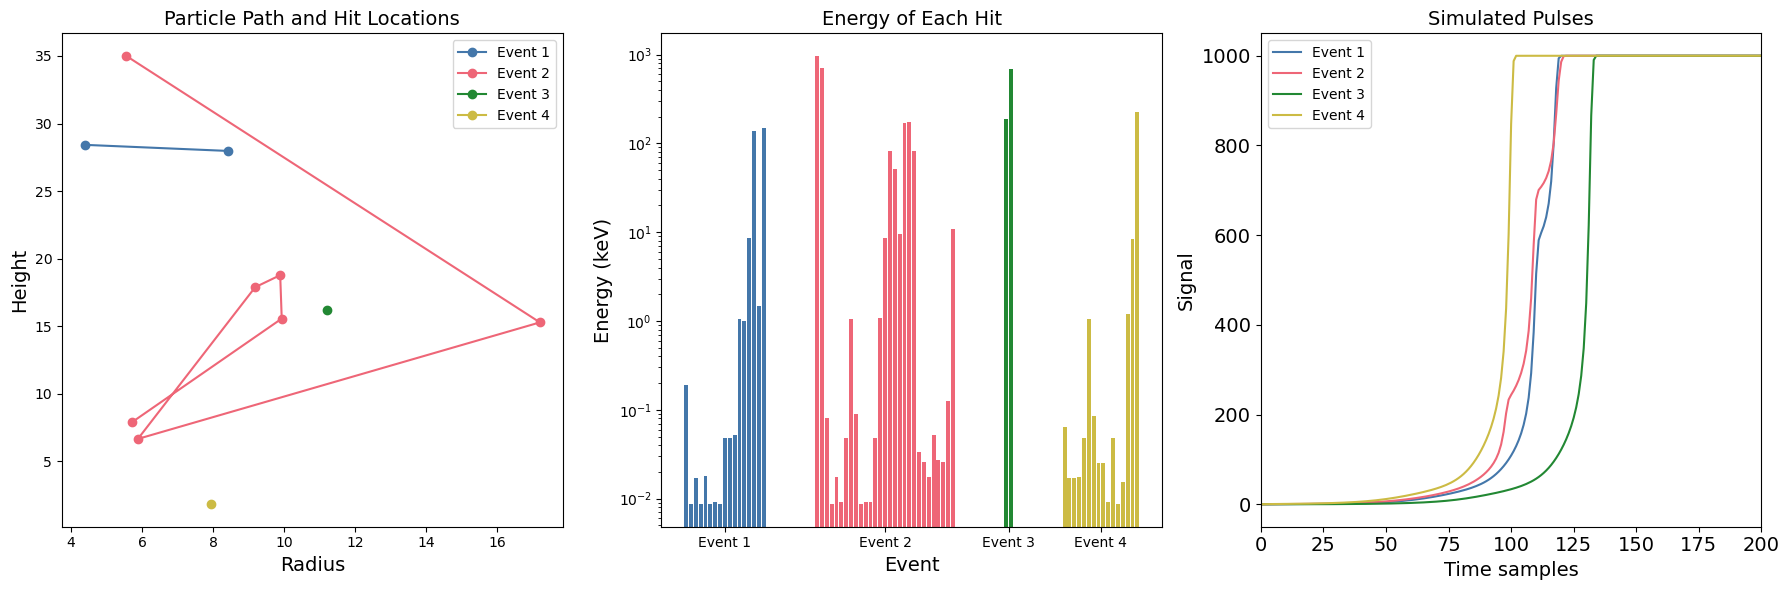

In [3]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import pandas as pd
import numpy as np
import os
import struct
import subprocess
import matplotlib.pyplot as plt
import json  # For saving and loading data
from tools import process_run_csv  # Ensure this function is properly defined to handle CSV processing.

# Parameters
selected_events = [29, 63, 47, 72] #34
distance_threshold = 1.0  # Minimum distance to consider a hit.

# Output file for saving plot data
plot_data_file = "plot_data.json"

# Prepare data storage
plot_data = {
    "events": [],
    "hits": [],
    "waveforms": [],
    "energies": [],
}

# Prepare plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Initialize for compressed x-axis
gap_scaling_factor = 10  # Adjust this to control the gap size between events.
compressed_x = []  # Store compressed x-axis values for hits.
compressed_colors = []  # Store colors corresponding to each event.

colors = [
    "#4477AA",  # Blue
    "#EE6677",  # Red
    "#228833",  # Green
    "#CCBB44",  # Yellow
    "#66CCEE",  # Sky Blue
    'tab:orange'
]

# Specify parameters
base_directory = "/work/users/k/b/kbhimani/cpu_net_g4sims/data_ornl/"
base_filename = "data_run_0.csv"
siggen_dir = "/nas/longleaf/home/kbhimani/ornl_sims/icpc_siggen/"
config_path = "/nas/longleaf/home/kbhimani/ornl_sims/icpc_siggen/config_files/V06649A.config"
stester_executable = os.path.join(siggen_dir, "stester")
output_dir = os.path.join(siggen_dir, "waveforms", "demo_hits")
os.makedirs(output_dir, exist_ok=True)
wf_len = 1000  # Waveform length.
offset = 1000000 + 1  # Offset for processing.

# Read and process data using process_run_csv
filename = os.path.join(base_directory, base_filename)
run_df = process_run_csv(filename, 0, offset)

# Map event IDs to simplified labels (1–4)
event_labels = {event_id: f"Event {idx+1}" for idx, event_id in enumerate(selected_events)}

# Process selected events
current_x = 0
for event_idx, event_id in enumerate(selected_events):
    event_hits = run_df[run_df['event'] == event_id]

    # Write stester command file
    command_file_path = os.path.join(output_dir, f"stester_commands_event_{event_id}.txt")
    with open(command_file_path, "w") as f:
        f.write("cart \n")
        f.write("tau 0\n")
        f.write("dif 1\n")
        f.write("ccs 0.1\n")
        for index, hit in event_hits.iterrows():
            waveform_filename = f"waveform_event{event_id}_hit{index}.spe"
            waveform_path = os.path.join(output_dir, waveform_filename)
            f.write(f"sig {abs(hit['x_hit']):.2f} {abs(hit['y_hit']):.2f} {hit['z_hit']:.2f} {waveform_path}\n")
        f.write("quit\n")

    # Run stester
    stester_command = f"{stester_executable} {config_path} < {command_file_path}"
    subprocess.run(stester_command, shell=True, check=False, stdout=subprocess.DEVNULL)
    os.remove(command_file_path)  # Clean up command file.

    # Initialize for aggregation
    aggregate_waveform = np.zeros(wf_len)
    total_deposited_energy = 0

    # Process waveform files
    for index, hit in event_hits.iterrows():
        waveform_filename = f"waveform_event{event_id}_hit{index}.spe"
        waveform_path = os.path.join(output_dir, waveform_filename)
        edep = hit['edep']

        try:
            with open(waveform_path, 'rb') as f:
                f.read(36)  # Skip header.
                yraw = f.read(wf_len * 4)  # Read waveform data.
                wf = np.array(struct.unpack('f' * wf_len, yraw))
                aggregate_waveform += wf * edep
                total_deposited_energy += edep
            os.remove(waveform_path)  # Clean up waveform file.
        except Exception as e:
            print(f"Error processing file {waveform_path}: {e}")
            continue

    # Compute energy-weighted average waveform
    if total_deposited_energy > 0:
        average_waveform = aggregate_waveform / total_deposited_energy
        average_waveform = np.nan_to_num(average_waveform)

        # Store data for later use
        plot_data["events"].append(event_labels[event_id])
        plot_data["hits"].append(event_hits.to_dict(orient="records"))
        plot_data["waveforms"].append(average_waveform.tolist())
        plot_data["energies"].append(event_hits["edep"].tolist())

        # Plot hit locations and particle path on the left (Position 1)
        positions = event_hits[['x_hit', 'y_hit']].to_numpy()
        distances = np.linalg.norm(np.diff(positions, axis=0), axis=1)

        # Filter hits that are too close
        valid_hits = [positions[0]]  # Always include the first hit.
        for i in range(1, len(positions)):
            if distances[i - 1] > distance_threshold:
                valid_hits.append(positions[i])
        valid_hits = np.array(valid_hits)

        # Plot the path
        axes[0].plot(abs(valid_hits[:, 0]), abs(valid_hits[:, 1]), marker='o', label=event_labels[event_id], color=colors[event_idx])
        
        # Plot waveforms on the right (Position 3)
        axes[2].plot(average_waveform, label=event_labels[event_id], color=colors[event_idx])
        
    # Assign compressed x-axis values for this event
    hit_count = len(event_hits)
    compressed_x.extend(np.arange(current_x, current_x + hit_count))
    compressed_colors.extend([colors[event_idx]] * hit_count)  # Assign color to each hit.
    current_x += hit_count + gap_scaling_factor  # Add scaled gap to the next event's starting point.

# Plot energy of each hit in the center (Position 2)
for x, edep, color in zip(compressed_x, run_df.loc[run_df['event'].isin(selected_events), 'edep'], compressed_colors):
    axes[1].bar(x, edep, color=color, log=True)

# Save plot data
with open(plot_data_file, "w") as f:
    json.dump(plot_data, f)

# Finalize plots
axes[0].set_title("Particle Path and Hit Locations", fontsize=14)
axes[0].set_xlabel("Radius", fontsize=14)
axes[0].set_ylabel("Height", fontsize=14)
axes[0].legend()

axes[1].set_title("Energy of Each Hit", fontsize=14)
axes[1].set_xlabel("Event", fontsize=14)
axes[1].set_ylabel("Energy (keV)", fontsize=14)

# Update x-axis tick labels for events
event_ticks = [np.mean(compressed_x[sum(len(h) for h in plot_data["hits"][:i]):sum(len(h) for h in plot_data["hits"][:i+1])]) for i in range(len(selected_events))]
axes[1].set_xticks(event_ticks)
axes[1].set_xticklabels([f"Event {i+1}" for i in range(len(selected_events))])

axes[2].set_title("Simulated Pulses", fontsize=14)
axes[2].set_xlabel("Time samples", fontsize=14)
axes[2].set_ylabel("Signal", fontsize=14)
axes[2].set_xlim(0, 200)  # Set x-axis limits
axes[2].legend()

# Tick labels size
plt.xticks(fontsize=14)  # Bigger tick labels
plt.yticks(fontsize=14)  # Bigger tick labels

plt.tight_layout()
plt.savefig('figs/hit_sims.pdf', dpi=300)
plt.show()


Error processing file /nas/longleaf/home/kbhimani/ornl_sims/icpc_siggen/waveforms/demo_hits/waveform_event63_hit682.spe: [Errno 2] No such file or directory: '/nas/longleaf/home/kbhimani/ornl_sims/icpc_siggen/waveforms/demo_hits/waveform_event63_hit682.spe'


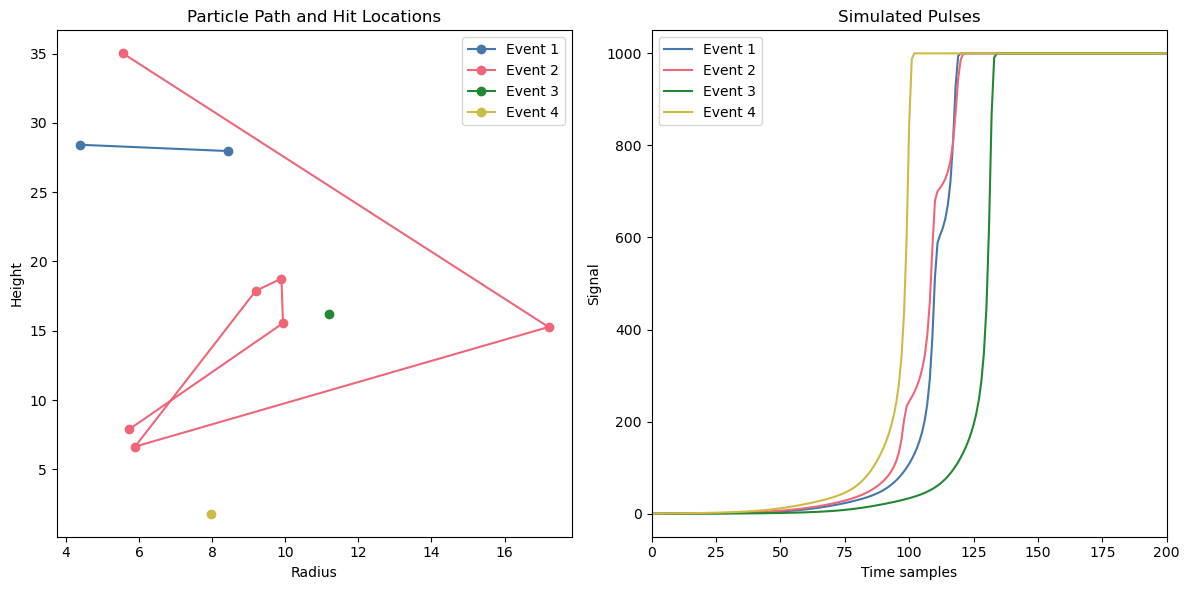

In [3]:
import pandas as pd
import numpy as np
import os
import struct
import subprocess
import matplotlib.pyplot as plt
import json  # For saving and loading data
from tools import process_run_csv  # Ensure this function is properly defined to handle CSV processing.

# Parameters
selected_events = [29, 63, 47, 72] #34
distance_threshold = 1.0  # Minimum distance to consider a hit.

# Output file for saving plot data
plot_data_file = "plot_data.json"

# Prepare data storage
plot_data = {
    "events": [],
    "hits": [],
    "waveforms": [],
}

# Prepare plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create only two plots now: hits and pulses

# Initialize for compressed x-axis
colors = [
    "#4477AA",  # Blue
    "#EE6677",  # Red
    "#228833",  # Green
    "#CCBB44",  # Yellow
    "#66CCEE",  # Sky Blue
    'tab:orange'
]

# Map event IDs to simplified labels (1–4)
event_labels = {event_id: f"Event {idx+1}" for idx, event_id in enumerate(selected_events)}

# Process selected events
for event_idx, event_id in enumerate(selected_events):
    event_hits = run_df[run_df['event'] == event_id]

    # Write stester command file
    command_file_path = os.path.join(output_dir, f"stester_commands_event_{event_id}.txt")
    with open(command_file_path, "w") as f:
        f.write("cart \n")
        f.write("tau 0\n")
        f.write("dif 1\n")
        f.write("ccs 0.1\n")
        for index, hit in event_hits.iterrows():
            waveform_filename = f"waveform_event{event_id}_hit{index}.spe"
            waveform_path = os.path.join(output_dir, waveform_filename)
            f.write(f"sig {abs(hit['x_hit']):.2f} {abs(hit['y_hit']):.2f} {hit['z_hit']:.2f} {waveform_path}\n")
        f.write("quit\n")

    # Run stester
    stester_command = f"{stester_executable} {config_path} < {command_file_path}"
    subprocess.run(stester_command, shell=True, check=False, stdout=subprocess.DEVNULL)
    os.remove(command_file_path)  # Clean up command file.

    # Initialize for aggregation
    aggregate_waveform = np.zeros(wf_len)
    total_deposited_energy = 0

    # Process waveform files
    for index, hit in event_hits.iterrows():
        waveform_filename = f"waveform_event{event_id}_hit{index}.spe"
        waveform_path = os.path.join(output_dir, waveform_filename)
        edep = hit['edep']

        try:
            with open(waveform_path, 'rb') as f:
                f.read(36)  # Skip header.
                yraw = f.read(wf_len * 4)  # Read waveform data.
                wf = np.array(struct.unpack('f' * wf_len, yraw))
                aggregate_waveform += wf * edep
                total_deposited_energy += edep
            os.remove(waveform_path)  # Clean up waveform file.
        except Exception as e:
            print(f"Error processing file {waveform_path}: {e}")
            continue

    # Compute energy-weighted average waveform
    if total_deposited_energy > 0:
        average_waveform = aggregate_waveform / total_deposited_energy
        average_waveform = np.nan_to_num(average_waveform)

        # Store data for later use
        plot_data["events"].append(event_labels[event_id])
        plot_data["hits"].append(event_hits.to_dict(orient="records"))
        plot_data["waveforms"].append(average_waveform.tolist())

        # Plot hit locations
        positions = event_hits[['x_hit', 'y_hit']].to_numpy()
        distances = np.linalg.norm(np.diff(positions, axis=0), axis=1)

        # Filter hits that are too close
        valid_hits = [positions[0]]  # Always include the first hit.
        for i in range(1, len(positions)):
            if distances[i - 1] > distance_threshold:
                valid_hits.append(positions[i])
        valid_hits = np.array(valid_hits)

        # Plot the particle path on the left
        axes[0].plot(abs(valid_hits[:, 0]), abs(valid_hits[:, 1]), marker='o', label=event_labels[event_id], color=colors[event_idx])
        
        # Plot waveforms on the right
        axes[1].plot(average_waveform, label=event_labels[event_id], color=colors[event_idx])

# Save plot data
with open(plot_data_file, "w") as f:
    json.dump(plot_data, f)

# Finalize plots
axes[0].set_title("Particle Path and Hit Locations")
axes[0].set_xlabel("Radius")
axes[0].set_ylabel("Height")
axes[0].legend()

axes[1].set_title("Simulated Pulses")
axes[1].set_xlabel("Time samples")
axes[1].set_ylabel("Signal")
axes[1].set_xlim(0, 200)  # Set x-axis limits
axes[1].legend()

plt.tight_layout()
plt.savefig('figs/hits_and_pulses.pdf', dpi=100)
plt.show()


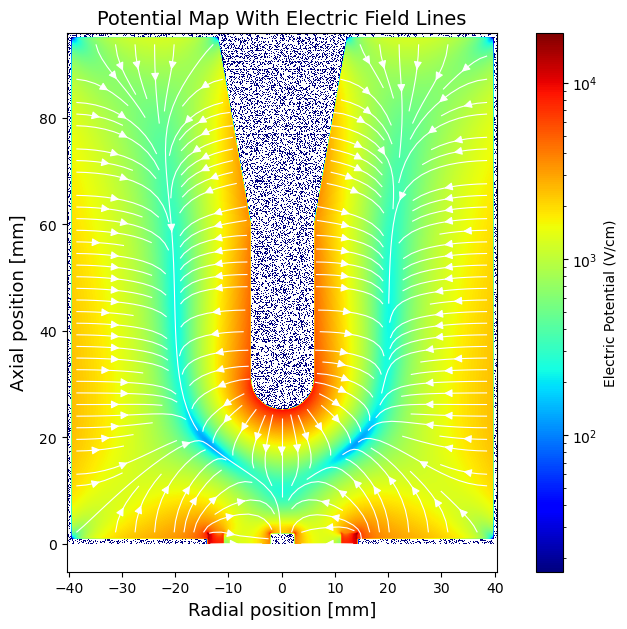

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Load data
data = np.loadtxt('/nas/longleaf/home/kbhimani/ornl_sims/icpc_siggen/fields/ev_V06649A.dat')

# Extract unique grid points and field data
x = np.unique(data[:, 0])  # Radial positions
y = np.unique(data[:, 1])  # Axial positions
z = data[:, 3]             # 2=Potential values 3= Electic field magnitude
E_r = data[:, 4]           # Radial electric field
E_z = data[:, 5]           # Axial electric field

# Reshape data
zvals = z.reshape(len(x), len(y))
zvals[zvals < 0] = 0  # Replace negative values with 0

# Create a symmetric potential map
zvals_neg = np.fliplr(zvals.T)  # Mirror for negative r-values
zvals_full = np.hstack((zvals_neg, zvals.T))  # Concatenate for full symmetry

# Extend the field values symmetrically
E_r_vals = E_r.reshape(len(x), len(y)).T
E_r_full = np.hstack((-np.fliplr(E_r_vals), E_r_vals))  # Symmetric radial field
E_z_vals = E_z.reshape(len(x), len(y)).T
E_z_full = np.hstack((np.fliplr(E_z_vals), E_z_vals))  # Symmetric axial field

# Create new symmetric grid
x_full = np.linspace(-max(x), max(x), 2 * len(x))  # Symmetric, strictly increasing
y_full = y  # Axial positions remain unchanged
X, Y = np.meshgrid(x_full, y_full)  # Meshgrid for the symmetric grid

# Plot potential map
fig, ax = plt.subplots(figsize=(10, 7))
bounds = (-1 * max(x), max(x), min(y), max(y))
ip = ax.imshow(zvals_full, norm=colors.LogNorm(),
               extent=bounds, origin="lower", cmap='jet')
plt.colorbar(ip, label="Electric Potential (V/cm)")

# Add electric field lines
ax.streamplot(X, Y, E_r_full, E_z_full, color='white', linewidth=0.8, density=1.5, arrowsize=1.2)

# Add labels and title
plt.xlabel("Radial position [mm]", size=13)
plt.ylabel("Axial position [mm]", labelpad=8, size=13)
plt.title("Potential Map With Electric Field Lines", size=14)

# Show the plot
plt.show()
